In [9]:
import numpy as np
import pandas as pd
import torch

import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset

from Dataset.economy import EconomyDataset
from Model.LSTM import LSTM

import matplotlib.pyplot as plt

In [10]:
# 데이터 다운 & 전처리

df = pd.read_excel('../데이터/economy/economy_all.xlsx')
df = df['국고채금리'].values

In [11]:
len_df = len(df)
train_len = int(len_df *0.6)
val_len = int(len_df * 0.3)

batch_size = 2

train_dataset = EconomyDataset(df[:train_len])
train_loader = DataLoader(train_dataset, batch_size=batch_size)

val_dataset = EconomyDataset(df[train_len:train_len+val_len])
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = EconomyDataset(df[train_len+val_len:])
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [12]:
for x,y in train_loader:
  print("X 크기 : {}".format(x.shape))
  print("Y 크기 : {}".format(y.shape))
  break

X 크기 : torch.Size([2, 5])
Y 크기 : torch.Size([2])


In [13]:
input_size = 5
hidden_size = 16
Model = LSTM(input_size, hidden_size)

In [14]:
# 데이터 & 모델에 device 붙임!!!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

model = Model.to(device)

print('작동하는지 실험')
basic_data = torch.rand((1,input_size))
model(basic_data)


cpu is available
작동하는지 실험


tensor([-0.0014], grad_fn=<SelectBackward0>)

In [15]:
criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epoch : 0
train
1.3448394675706994
Calculating validation results...
val
loss: 5.6672246 || 
epoch : 1
train
0.5116750596669214
Calculating validation results...
val
loss: 3.0466275 || 
epoch : 2
train
0.11345568346060363
Calculating validation results...
val
loss: 1.8001398 || 
epoch : 3
train
0.06656705814541432
Calculating validation results...
val
loss: 1.4915108 || 
epoch : 4
train
0.06584379419404411
Calculating validation results...
val
loss: 1.399035 || 
epoch : 5
train
0.06179316300240943
Calculating validation results...
val
loss: 1.3252503 || 
epoch : 6
train
0.05738405618588895
Calculating validation results...
val
loss: 1.2517578 || 
epoch : 7
train
0.05336249426627233
Calculating validation results...
val
loss: 1.1804441 || 
epoch : 8
train
0.04999502626115231
Calculating validation results...
val
loss: 1.114699 || 
epoch : 9
train


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.04738510272100343
Calculating validation results...
val
loss: 1.0576029 || 
epoch : 10
train
0.045403820808258326
Calculating validation results...
val
loss: 1.0100005 || 
epoch : 11
train
0.04385223315029148
Calculating validation results...
val
loss: 0.97086624 || 
epoch : 12
train
0.0425835510912544
Calculating validation results...
val
loss: 0.93863763 || 
epoch : 13
train
0.04150270383026258
Calculating validation results...
val
loss: 0.91183575 || 
epoch : 14
train
0.04054808450846708
Calculating validation results...
val
loss: 0.88921911 || 
epoch : 15
train
0.03967937297721651
Calculating validation results...
val
loss: 0.86979018 || 
epoch : 16
train
0.0388697712463407
Calculating validation results...
val
loss: 0.85276281 || 
epoch : 17
train
0.038101140473937166
Calculating validation results...
val
loss: 0.83752092 || 
epoch : 18
train
0.037360868470919927
Calculating validation results...
val
loss: 0.82358237 || 
epoch : 19
train
0.036640062305979944
Calculating validati

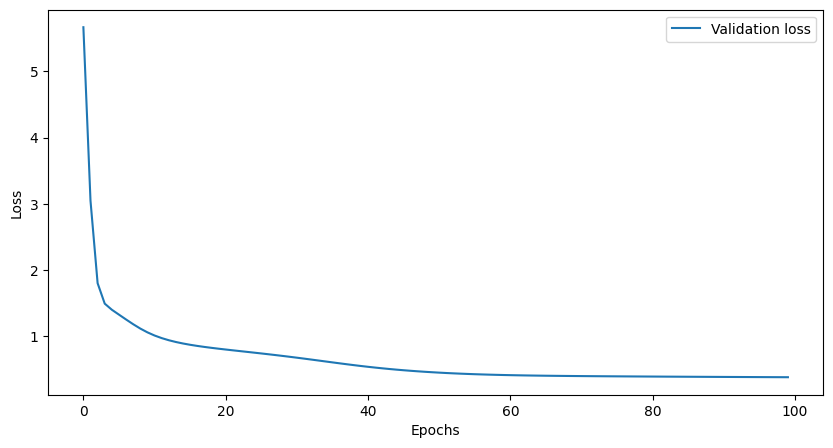

In [16]:
train_n = len(train_dataset)
val_n = len(val_dataset)

val_loss_list = []
best_val_loss = float('inf')
stop_counter = 0
stop_criteria = 3

for epoch in range(num_epochs):
    print('epoch : {}'.format(epoch))
    running_loss = 0.0
    num = 0
    print("train")
    model.train()
    for inputs, labels in train_loader:  # dataloader 함수에 def __len__에 return 값만큼 반복함
        inputs = inputs.to(device)
        labels = labels.to(device)
        out = model(inputs)
        loss = criterion(out, labels)

        optimizer.zero_grad() #
        loss.backward() # loss가 최소가 되게하는
        optimizer.step() # 어떤 방법으로 learning rate를 움직일거이냐
        running_loss += loss.item() # 한 배치의 loss 더해주고,


    print(running_loss/train_n)

    with torch.no_grad():
            print("Calculating validation results...")
            model.eval()
            val_loss = 0
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outs = model(inputs)

                loss= criterion(outs, labels)
                val_loss += loss.item()

            avg_val_loss = val_loss/val_n
            val_loss_list.append(avg_val_loss)

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                stop_counter = 0            
                torch.save(model.state_dict(), 'Checkpoint/economic_best_model.pth')
            else:
                stop_counter += 1

            print("val")
            print(
                f"loss: {avg_val_loss:4.8} || "
            )

            if stop_counter >= stop_criteria:
                print('Early stopping triggered.')
                break
    
    print('======================================================')

plt.figure(figsize=(10, 5))
plt.plot(val_loss_list, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()